In [ ]:
from river.datasets import synth
from clustream import CluStream
from river import drift
import math
import numpy as np
import matplotlib.pyplot as plt
from river.utils import dict2numpy
from scipy.spatial import distance_matrix
from time import time
from river import stream
import pandas as pd
from scipy.spatial import distance_matrix

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
import itertools




In [152]:
ds = pd.read_csv('./datasets/rbf speed 100l/rbf_speed_100L.csv')
#ds = pd.read_csv('./datasets/rbf create delete 2/rbf_create_delete_2.csv')
df = ds.copy()
y = df.pop('.class')
df.head()

,X1,X2
0,0.700619,0.211895
1,0.752499,0.203517
2,0.721374,0.221509
3,0.698130,0.162492
4,0.720398,0.168402


In [153]:
model = CluStream(n_macro_clusters=3,max_micro_clusters=20,micro_cluster_r_factor=0.01,time_window=400,time_gap=500)
test = drift.PageHinkley(min_instances=10,delta=0.04999,threshold=0.15,alpha=1,mode='up')

0.061031876642895694
0.04412038732828212
0.04340936496803173
0.04994687937531394
0.04819162613964733
0.0536616593511661
0.05960238837882574
0.07007179921027779
0.0823202593741576
0.08335504088451186
0.09041150790786226
0.10367399276356254
0.10822346959947828
0.11150610795400617
Drift detected at instance: 1331 
0.12296189759205137
0.13678874306961256
0.14335251397317497
0.1442568970379317
0.15374080681823757
0.1575423849853978
0.15738682887077857
Drift detected at instance: 2079 
0.16474309488523653
0.16797813633021721
0.18088485806580232
0.18916405600101857
0.1849592893936819
Drift detected at instance: 2564 
0.19751309366938208
0.2088562276815524
0.1999119982377177
0.20363227815363483


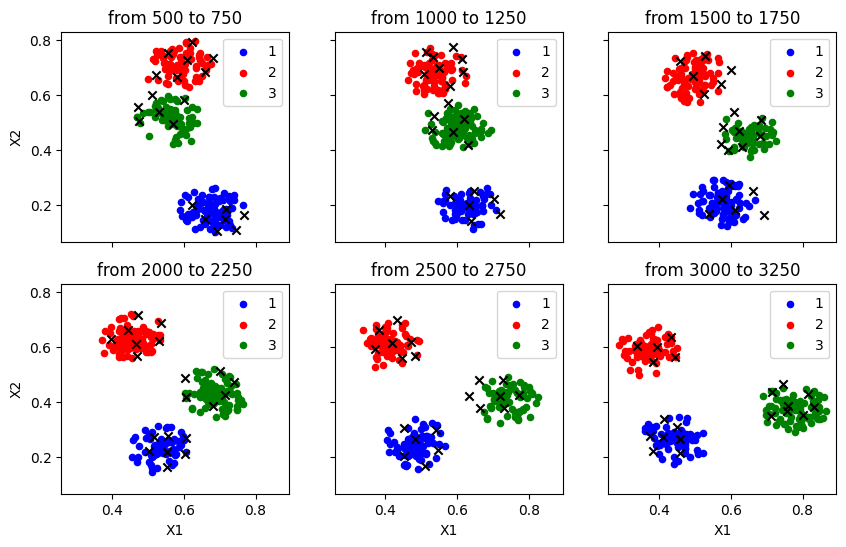

In [154]:
fig ,ax = plt.subplots(2,3,figsize=(10,6),sharex=True, sharey= True)
it = itertools.product((0,1,2),(0,1,2))
colors = {1 : 'blue', 2 : 'red', 3 : 'green', 4 : 'purple' , 5 : 'cyan', 6 : 'orange' , 7 : 'yellow', 8 : 'black' }
i = 0
j = 0
go = True
dist = []
for x,y in stream.iter_pandas(df,y):
    model = model.learn_one(x)
    i +=1

    if model._initialized :
        if go :
            model.offline_cluster()
            go = False
        test = test.update(model.dist_center(x))
        if test.drift_detected :
             print(f'Drift detected at instance: {i} ')
        dist.append(model.dist_center(x))
        if j % 100 == 0:
            print(np.mean(dist))
            dist = []
        j += 1

    if i % 500 == 0 :

        k,m = next(it)
        centroids = model.get_micro_clusters()
        grouped = ds[i:i+250].groupby('.class')
        for key,group in grouped :
            group.plot(ax=ax[k,m],x='X1',y='X2',kind="scatter",label = key,color=colors[key],title=f'from {i} to {i + 250}')
        ax[k,m].scatter(centroids[:,0],centroids[:,1],marker="x",c='black')
        # ax[k,m].scatter(model.centers[:,0],model.centers[:,1],marker='o',c='white')
    
    if i ==3000 :
        break
    
    
        

   
fig.savefig('window_150_30mc')